#### Analyze the `NicheCompass` results on Xenium adult healthy colon data add-on dataset (425 probes)
- **Developed by:** Anna Maguza
- **Affilation:** Faculty of Medicine, Würzburg University
- **Created date:** 25th March 2024
- **Last modified dte:** 21st October 2024

This notebook is created to analyze niche composition and gene programs in the stem cells niche.

#### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
from pywaffle import Waffle
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import anndata as ad

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

+ The following function creates list of colors that we can use for waffle plot

In [3]:
def create_color_list(
        df,
        cat_column='Cell_State',
        color_palette="default",
        overwrite_color_dict={"-1" : "#E1D9D1"},
        skip_default_colors=0):
    categories = df[cat_column].unique()
    
    if color_palette == "cell_type_30":
        colors = ['#FF76CE',  # bright pink
                '#E9A8F2',  # light lavender
                '#94FFD8',  # mint green
                '#A3D8FF',  # light sky blue
                '#FFA27F',  # light coral
                '#982B1C',  # bricks color
                '#43766C',  #dark teal
                '#759EB8',  #steel blue
                '#824670',  # deep purple
                '#ff4a46',  # bright red-orange
                '#97be5a',  # olive green (same as Glial cells)
                '#9467bd',  # medium purple
                '#34af85',  # sea green
                '#15becf',  # turquoise
                '#0000a6',  # dark blue
                '#a30159',  # deep magenta
                '#605678',  # purple-grey
                '#F05A7E',  # bright pink-red
                '#D7C3F1',  # pale lavender
                '#00712D',  # dark green
                '#FFFBE6',  # very pale yellow
                '#FFF4B5',  # light yellow
                '#7EACB5',  # grayish blue-green
                '#81DAE3',  # light turquoise
                '#6A9C89',  # muted teal
                '#FF77B7'   # bright pink
    ]
    elif color_palette == "cell_type_20":
        colors = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf',
                  '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d', '#9edae5',
                  '#ad494a', '#8c6d31']
    elif color_palette == "cell_type_10":
        colors = ['#7f7f7f', '#ff7f0e', '#279e68', '#e377c2', '#17becf', '#8c564b', '#d62728', '#1f77b4', '#b5bd61', '#aa40fc']
    elif color_palette == "batch":
        colors = ['#0173b2', '#d55e00', '#ece133', '#ca9161', '#fbafe4', '#949494', '#de8f05', '#029e73', '#cc78bc', '#56b4e9',
                  '#F0F8FF', '#FAEBD7', '#00FFFF', '#7FFFD4', '#F0FFFF', '#F5F5DC', '#FFE4C4', '#000000', '#FFEBCD', '#0000FF',
                  '#8A2BE2', '#A52A2A', '#DEB887', '#5F9EA0', '#7FFF00', '#D2691E', '#FF7F50', '#6495ED', '#FFF8DC', '#DC143C']
    elif color_palette == "default":
        cmap = plt.get_cmap('tab20')
        colors = [mcolors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(categories))]
        colors = colors[skip_default_colors:]
    else:
        raise ValueError(f"Unknown color palette: {color_palette}")

    # Ensure we have enough colors
    if len(colors) < len(categories):
        colors = colors * (len(categories) // len(colors) + 1)

    color_dict = dict(zip(categories, colors[:len(categories)]))
    
    # Apply overwrite colors
    for key, val in overwrite_color_dict.items():
        if key in color_dict:
            color_dict[key] = val
    
    # Create a list of colors matching the length of the DataFrame
    color_list = [color_dict[cat] for cat in df[cat_column]]
    
    return color_list

#### Define Parameters

In [4]:
latent_key = "nichecompass_latent"

gp_names_key = "nichecompass_gp_names"
cell_type_key = "Cell_State"
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "Donor_ID"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

#### Run Notebook Setup

In [5]:
warnings.filterwarnings("ignore")

#### Configure Paths

In [6]:
load_timestamp = '21102024_150114'

In [8]:
artifacts_folder_path = f"data/10X_Xenium_adult_colon_data/NicheCompass/artifacts"
model_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/figures"

#### Analysis

In [9]:
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 425, n_cat_covariates_embed_input: 0, n_hidden: 207, n_latent: 107, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 107, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 425
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 107, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 425


In [10]:
samples = model.adata.obs[sample_key].unique().tolist()

In [11]:
model.adata

AnnData object with n_obs × n_vars = 274037 × 425
    obs: 'Study_name', 'Donor_ID', 'Library_Preparation_Protocol', 'dataset', '_scvi_batch', '_scvi_labels', 'seed_labels', 'C_scANVI', 'SC_subsets', 'Cell_State', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'REG4_score', 'gdT', 'Endothelial cells'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'B cells_colors', 'BEST4+ epithelial_colors', 'CD4 T_colors', 'CD8 T_colors', 'C_scANVI_colors', 'Cell_State_colors', 'Colonocyte_colors', 'DC_colors', 'Deep_crypt_secretory_colors', 'Donor_ID_colors', 'EECs_colors', 'Endothelial cells_colors', 'Enterocyte_colors', 'FXYD3+_CKB+_SC_colors', 'Fibroblasts_colors', 'Glial cells_colors', 'Goblet cells_colors', 'ILCs_colors', 'LEC_colors', 'Library_Preparation_Protocol_colors', 'MTRNR2L12+ASS1+_SC_colors', 'Macro

#### Visualize NicheCompass Latent GP Space

In [12]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

In [13]:
adata = model.adata.copy()

In [ ]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14), dpi=300)
title = fig.suptitle(t=f"Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata, 
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sq.pl.spatial_scatter(adata, 
              library_id="spatial", 
              shape=None,
              color="Cell_State",
              size=0.2,
              title=f"Cell Types in Physical Space \n"
                    f"(Sample: {sample})",
              legend_loc=None, 
              frameon=False,
              ax=axs[idx+1], 
              alpha=1.0)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

#### 4.2 Identify Niches

+ Compute latent Leiden clustering

In [14]:
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [15]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

In [58]:
adata = model.adata.copy()

In [ ]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14), dpi = 300)
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sq.pl.spatial_scatter(adata,
                          library_id="spatial",
                          shape=None,
                          color=[latent_cluster_key],
                          size=0.2,
                          title=f"Niches in Physical Space \n"
                              f"(Sample: {sample})",
                          legend_loc=None,
                          frameon=False,
                          ax=axs[idx+1])

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

+ Get closer look on the niches

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(20, 20))
    sq.pl.spatial_scatter(
        model.adata,
        library_id="spatial",
        shape=None,
        color=["latent_leiden_0.4"],
        wspace=12,
        size=0.2,
        frameon=False,
        alpha=1.0
    )
    plt.savefig(f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_physical_space.svg")

#### 4.3 Characterize Niches

+ 4.3.1 Niche Composition

In [ ]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.png"

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True, figsize=(10, 10))
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight",
                dpi=300)  

In [66]:
df_counts.head(22)

Cell_State,Arterial capillary,B cells,BEST4+ epithelial,CD4 T,CD8 T,Colonocyte,DC,Deep_crypt_secretory,EECs,Endothelial cells,...,Microfold cell,Monocytes,Myofibroblasts,NK,Pericytes,Plasma cells,RPS10+_RPS17+_SC,TA,Tregs,Tuft cells
latent_leiden_0.4,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,20,43,0,15,0,0,419,...,0,7,25360,5,217,3,0,0,0,0
1,26,607,1,1313,335,0,92,5,848,1185,...,0,11,509,17,155,1129,824,1106,2,1728
2,6,133,0,213,134,0,30,0,2,1211,...,0,74,107,32,4511,104,3,9,1,4
3,27,10939,3,6313,217,8,627,1,3,341,...,12,4,155,5,29,540,10,50,24,41
4,64,120,21,1411,367,5,199,1,32,1301,...,0,12,370,13,83,6096,65,158,0,19
5,95,0,2275,1,84,12828,19,19,54,11,...,2,14,0,224,0,42,0,0,0,1
6,987,39,11,1614,317,69,1105,0,3,899,...,0,3,103,16,27,6749,0,18,0,0
7,1803,0,1065,166,103,5692,1100,12,28,258,...,0,1,1,93,9,453,0,2,0,4
8,1,2,0,98,81,0,24,0,0,832,...,0,258,6881,8,646,1,0,0,0,0


In [67]:
df_counts.to_csv(f"{figure_folder_path}/niche_composition.csv")

+ Waffle plot with the niche 14

In [79]:
niche14 = df_counts.iloc[14, 1:]

In [80]:
filtered_niche14 = niche14[niche14 >= 10]

sorted_niche14 = filtered_niche14.sort_values(ascending=False)

In [81]:
sorted_niche14 = pd.DataFrame({
    'Cell_State': sorted_niche14.index,
    'Number_of_Cells': sorted_niche14.values
})

In [ ]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

In [116]:
color_list = create_color_list(sorted_niche14, cat_column='Cell_State', color_palette="cell_type_30")

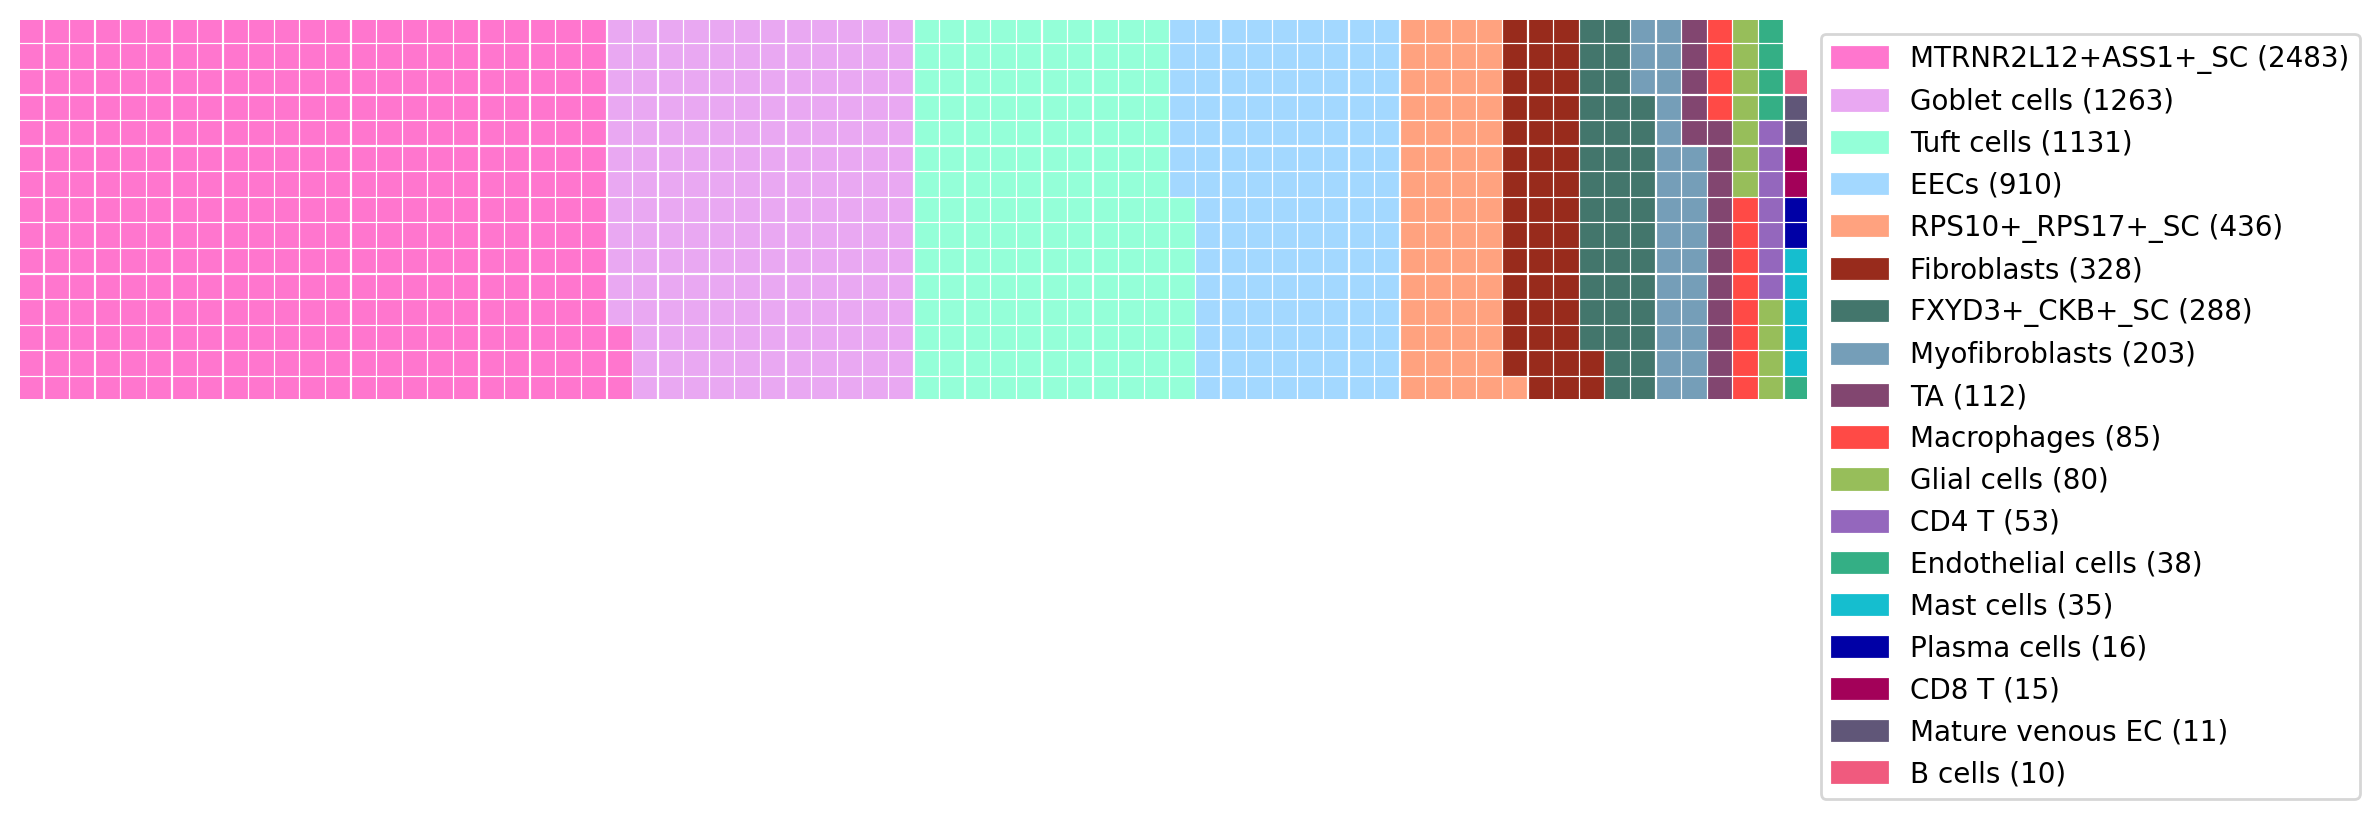

In [119]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=15,
    columns=70,
    values=sorted_niche14['Number_of_Cells'],
    labels=[f"{label} ({value})" for label, value in zip(sorted_niche14['Cell_State'], sorted_niche14['Number_of_Cells'])],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    figsize=(12, 8),
    colors=color_list
)
plt.savefig(f"{figure_folder_path}/niche_14.png", dpi=300)
plt.show()

+ Waffle plot with the niche 1

In [130]:
niche1 = df_counts.iloc[1, 1:]
niche1 = niche1[niche1 >= 10]

niche1 = niche1.sort_values(ascending=False)
niche1 = pd.DataFrame({
    'Cell_State': niche1.index,
    'Number_of_Cells': niche1.values
})

In [131]:
color_list = create_color_list(niche1, cat_column='Cell_State', color_palette="cell_type_30")

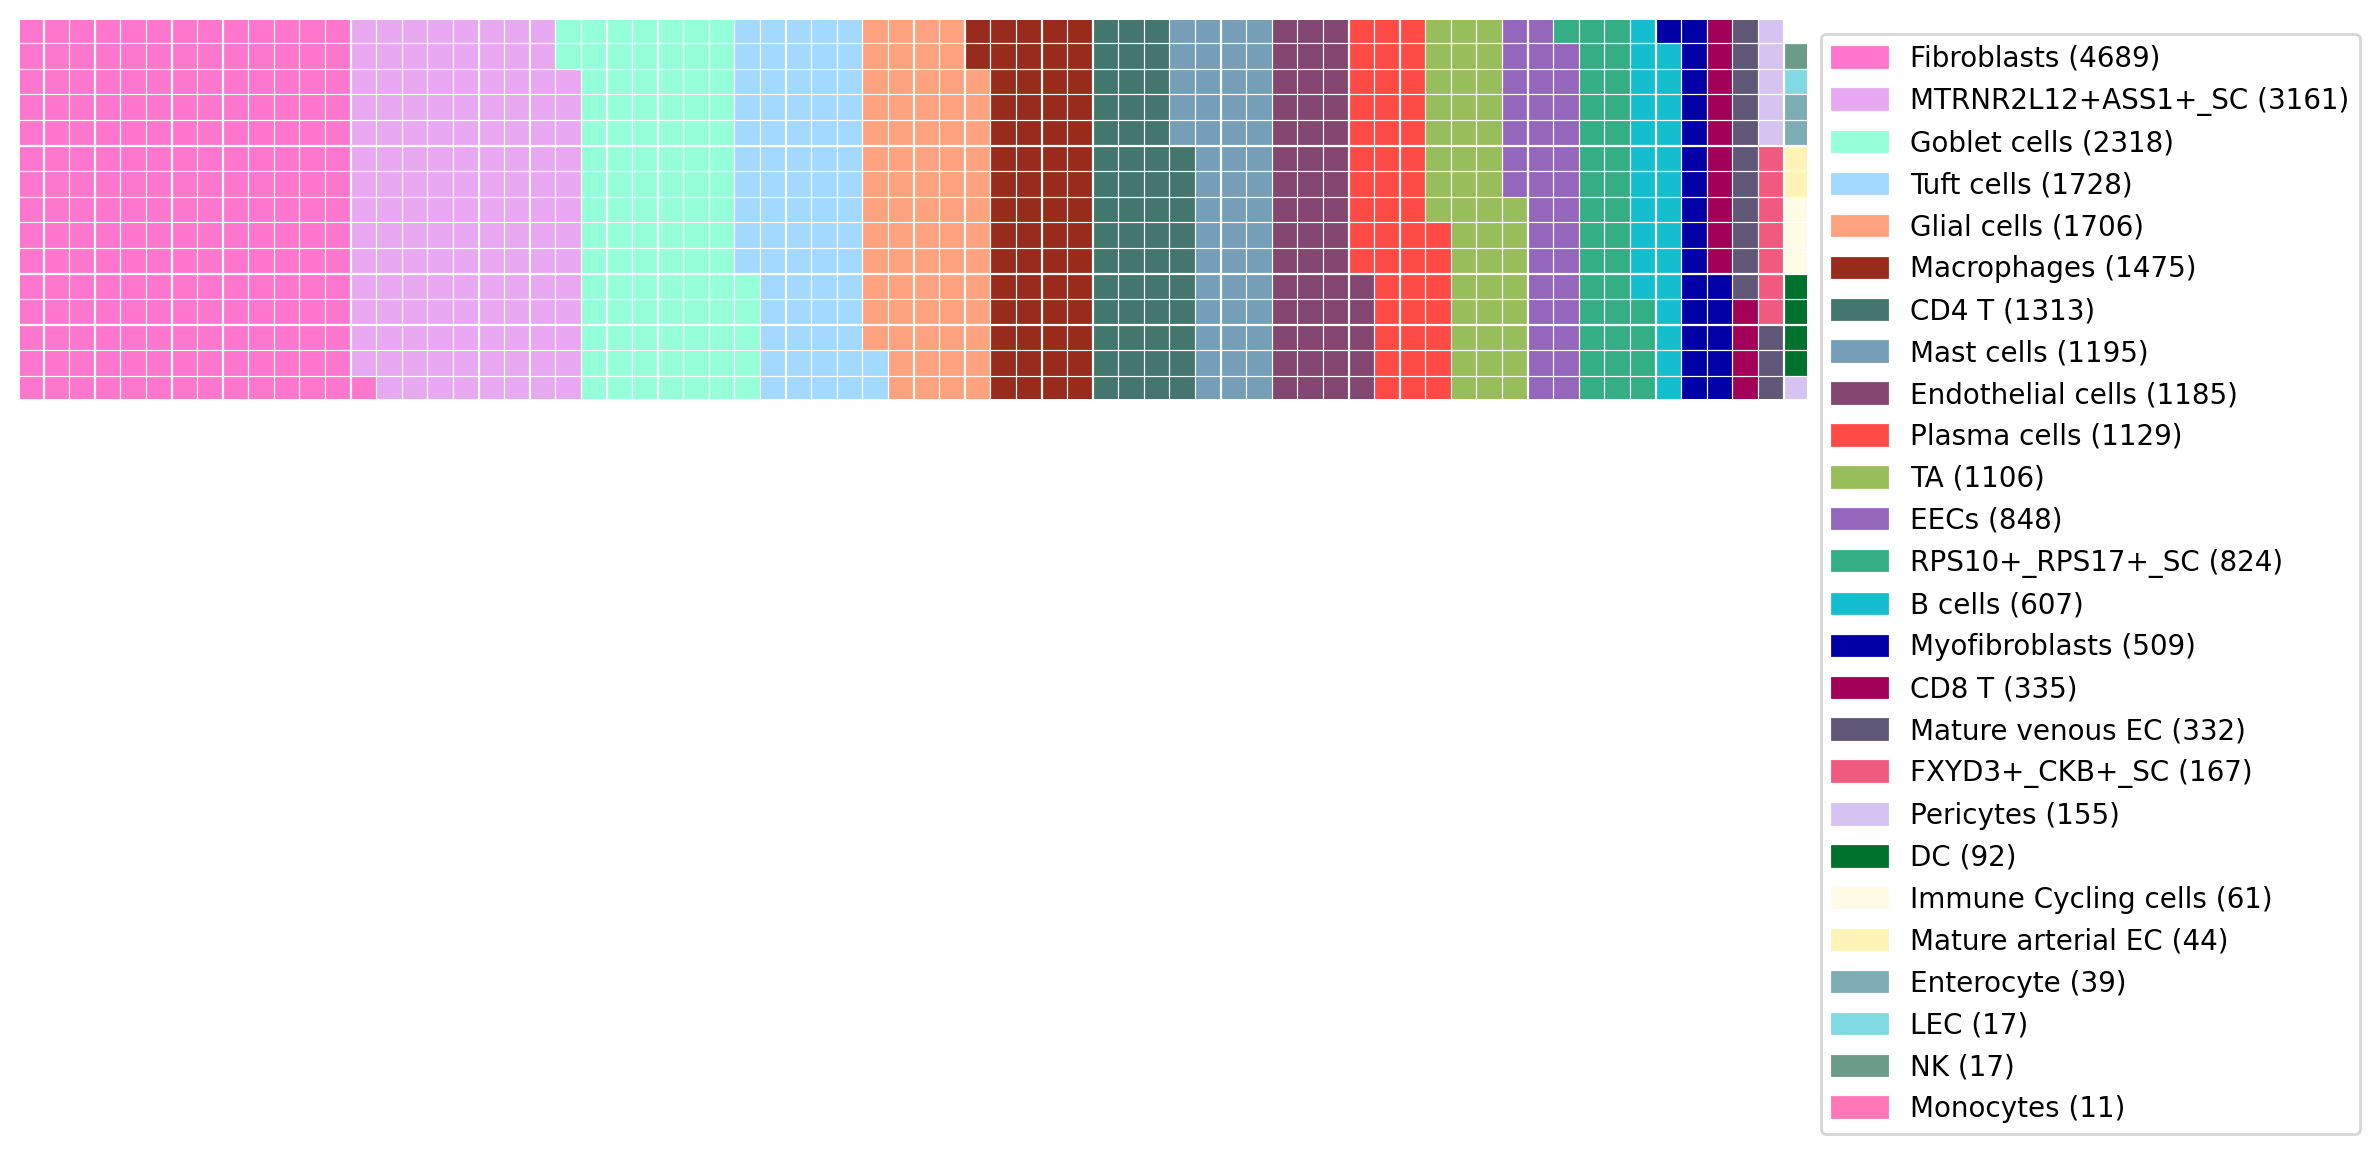

In [132]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=15,
    columns=70,
    values=niche1['Number_of_Cells'],
    labels=[f"{label} ({value})" for label, value in zip(niche1['Cell_State'], niche1['Number_of_Cells'])],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    figsize=(12, 8),
    colors=color_list
)
plt.savefig(f"{figure_folder_path}/niche_1.png", dpi=300)
plt.show()

+ Waffle plot with the niche 11

In [133]:
niche11 = df_counts.iloc[11, 1:]
niche11 = niche11[niche11 >= 10]

niche11 = niche11.sort_values(ascending=False)
niche11 = pd.DataFrame({
    'Cell_State': niche11.index,
    'Number_of_Cells': niche11.values
})

In [134]:
color_list = create_color_list(niche11, cat_column='Cell_State', color_palette="cell_type_30")

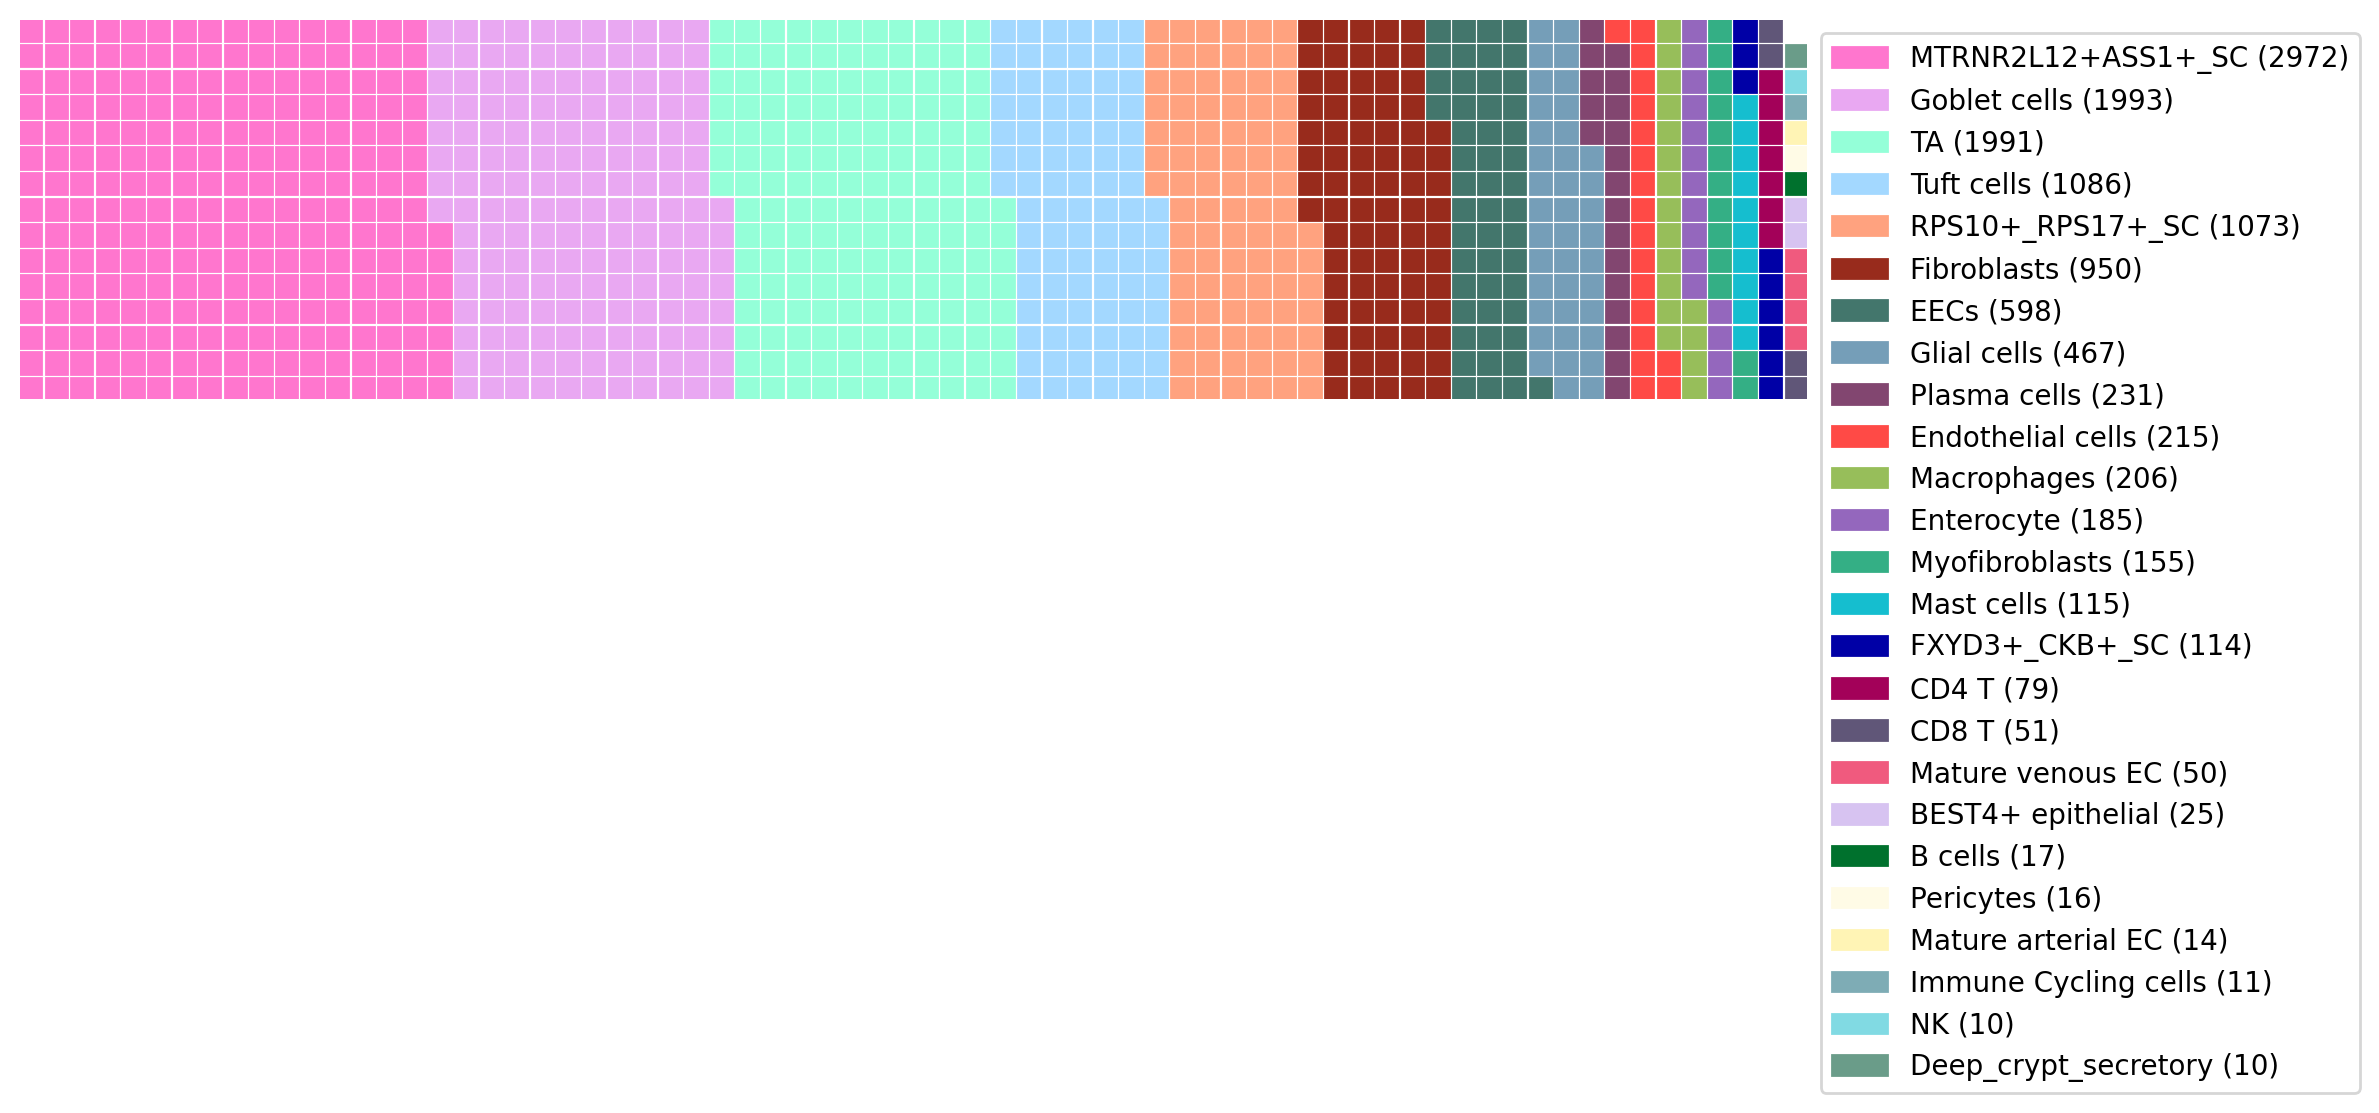

In [135]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=15,
    columns=70,
    values=niche11['Number_of_Cells'],
    labels=[f"{label} ({value})" for label, value in zip(niche11['Cell_State'], niche11['Number_of_Cells'])],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    figsize=(12, 8),
    colors=color_list
)
plt.savefig(f"{figure_folder_path}/niche_11.png", dpi=300)
plt.show()

+ 4.3.2 Differential GPs

In [16]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 207.
Number of active gene programs: 207.


In [17]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,gp_source_genes_weights,gp_target_genes_weights,gp_source_genes_importances,gp_target_genes_importances
0,CXCL10_ligand_receptor_GP,0,True,0,1,1,1,1,[CXCL10],[CXCR1],[0.81],[-0.013],[0.9841],[0.0159]
1,CCL13_ligand_receptor_GP,1,True,1,1,1,1,1,[CCL13],[CXCR2],[0.0136],[-0.0199],[0.4068],[0.5932]
2,CD177_ligand_receptor_GP,2,True,2,1,1,1,1,[CD177],[PECAM1],[2.0958],[-0.2983],[0.8754],[0.1246]
3,gamma-Aminobutyric acid_metabolite_enzyme_sens...,3,True,3,1,1,1,1,[ALDH1B1],[SLC6A8],[-2.8909],[0.8468],[0.7734],[0.2266]
4,Norepinephrine_metabolite_enzyme_sensor_GP,4,True,4,1,1,1,1,[MAOB],[ADRA2A],[4.3683],[4.4028],[0.498],[0.502]


In [31]:
model.adata.uns['nichecompass_gp_summary'] = gp_summary_df

### Differential gp testing

In [25]:
selected_cats = None
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = False
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [26]:
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [27]:
model.adata.uns[differential_gp_test_results_key]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,0,CD24_ligand_receptor_target_gene_GP,1.000000e+00,3.130829e-13,27.358643
1,0,SLPI_ligand_receptor_target_gene_GP,2.030341e-10,1.000000e+00,-22.312734
2,0,CXCL14_ligand_receptor_target_gene_GP,9.999940e-01,6.020830e-06,12.020279
3,0,ANPEP_ligand_receptor_target_gene_GP,9.999741e-01,2.592834e-05,10.560148
4,16,IL1B_ligand_receptor_target_gene_GP,9.993353e-01,6.647049e-04,7.315503
...,...,...,...,...,...
387,3,GUCA2A_ligand_receptor_target_gene_GP,8.972170e-02,9.102783e-01,-2.317038
388,3,Add-on_46_GP,9.102105e-01,8.978948e-02,2.316208
389,9,Add-on_71_GP,9.042616e-02,9.095738e-01,-2.308443
390,11,Add-on_79_GP,9.091360e-01,9.086396e-02,2.303131


In [34]:
adata = model.adata.copy()
adata

AnnData object with n_obs × n_vars = 274037 × 425
    obs: 'Study_name', 'Donor_ID', 'Library_Preparation_Protocol', 'dataset', '_scvi_batch', '_scvi_labels', 'seed_labels', 'C_scANVI', 'SC_subsets', 'Cell_State', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'REG4_score', 'gdT', 'Endothelial cells', 'latent_leiden_0.4', 'CD24_ligand_receptor_target_gene_GP', 'SLPI_ligand_receptor_target_gene_GP', 'CXCL14_ligand_receptor_target_gene_GP', 'ANPEP_ligand_receptor_target_gene_GP', 'IL1B_ligand_receptor_target_gene_GP', 'TIMP3_ligand_receptor_target_gene_GP', 'CDH1_ligand_receptor_target_gene_GP', 'TNXB_ligand_receptor_target_gene_GP', 'CLU_ligand_receptor_target_gene_GP', 'TFF1_ligand_receptor_target_gene_GP', 'CCL11_ligand_receptor_target_gene_GP', 'ROBO1_ligand_receptor_target_gene_GP', 'NRG3_ligand_receptor_

In [36]:
# Convert all elements in adata.uns to strings
for key in adata.uns.keys():
    adata.uns[key] = str(adata.uns[key])

In [37]:
project = 'xenium_adult_colon'
species = 'hs'
atribute = 'NicheCompass'
name = 'AM'
counts = 'raw'
adata.write_h5ad(f"{model_folder_path}/{project}_{species}_{atribute}_{name}_{load_timestamp}_{counts}.h5ad")

### Analyze stem cells niche 14

In [138]:
# Set parameters for differential gp testing
selected_cats = ["14"]
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = False
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [139]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [141]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,14,NRG3_ligand_receptor_target_gene_GP,0.998082,0.001918,6.254586
1,14,FCER2_ligand_receptor_target_gene_GP,0.007339,0.992661,-4.907195
2,14,COL19A1_ligand_receptor_target_gene_GP,0.010754,0.989246,-4.521693
3,14,Add-on_13_GP,0.986554,0.013446,4.295535
4,14,Add-on_35_GP,0.985654,0.014346,4.229869
5,14,Add-on_4_GP,0.017414,0.982586,-4.032922
6,14,Add-on_44_GP,0.017643,0.982357,-4.019590
7,14,UCN3_ligand_receptor_target_gene_GP,0.021916,0.978084,-3.798377
8,14,Add-on_26_GP,0.977959,0.022041,3.792567
9,14,Add-on_12_GP,0.968736,0.031264,3.433526


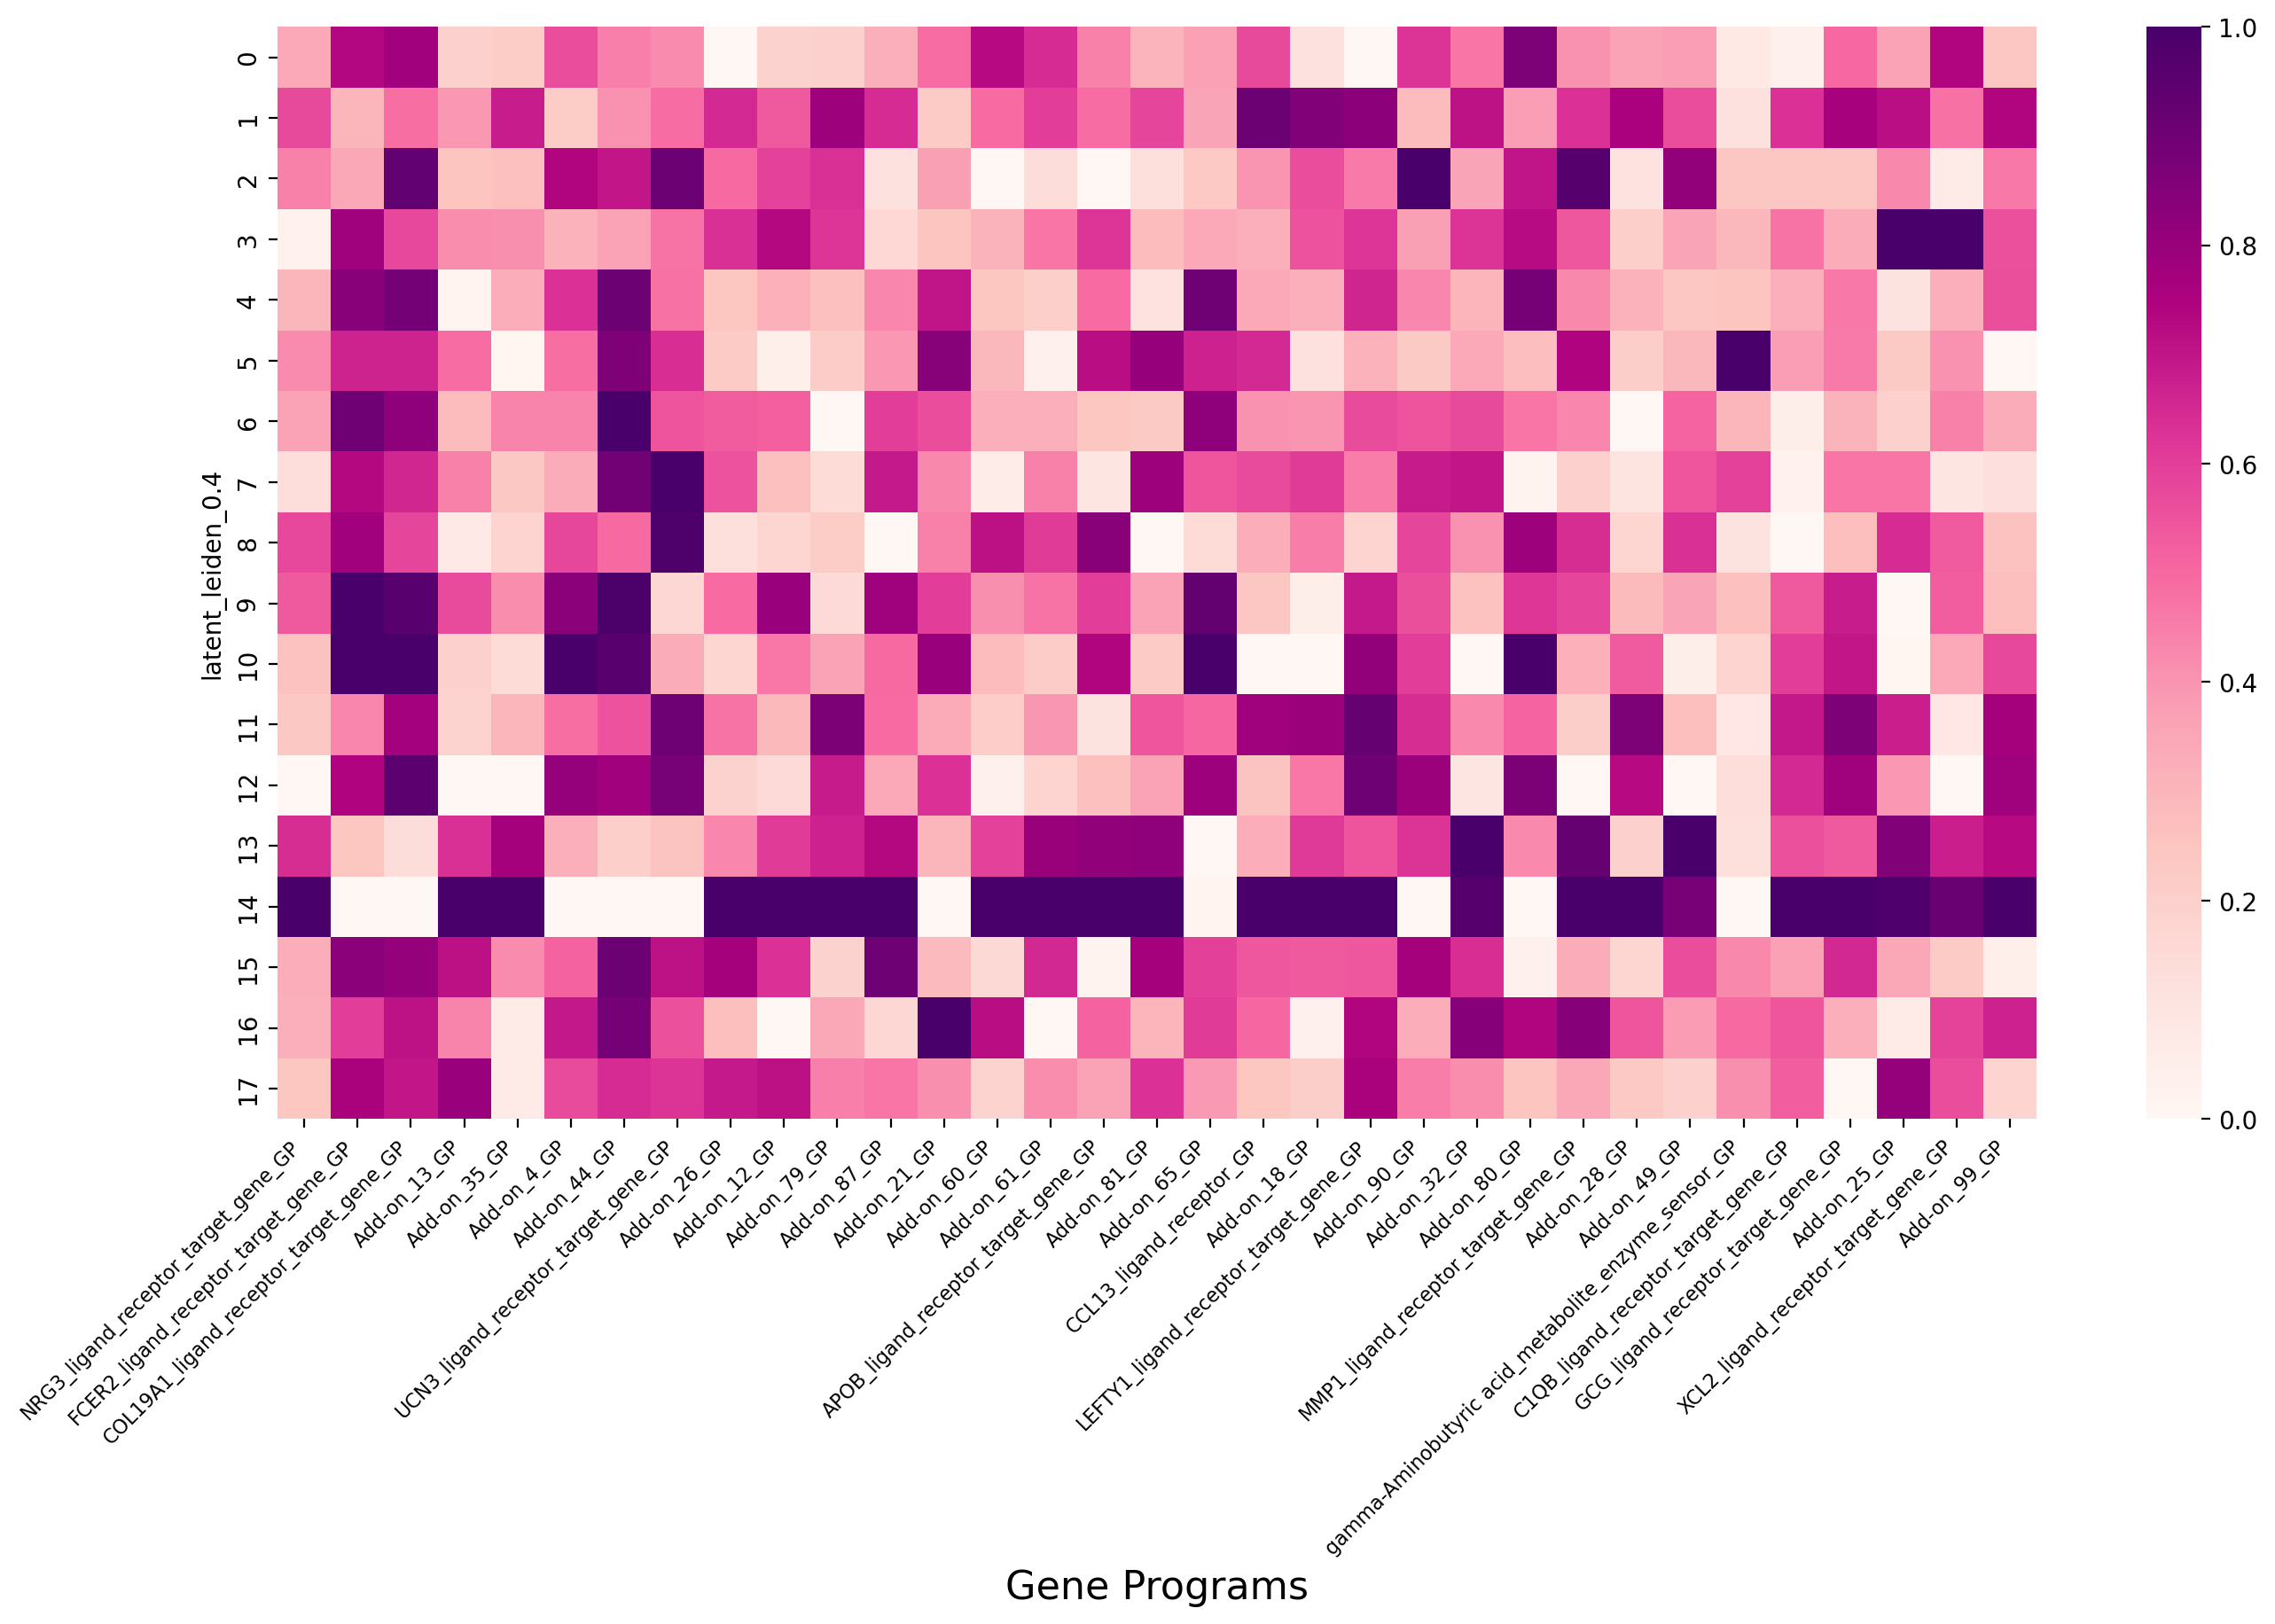

In [143]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='RdPu',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap_niche14.png",
            bbox_inches="tight", dpi=300)

In [144]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche14_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

#### Visualizations of GPs in Niche 14

In [145]:
adata = model.adata.copy()

In [146]:
adata_log = adata.copy()
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)

In [147]:
model.adata.uns[differential_gp_test_results_key]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,14,NRG3_ligand_receptor_target_gene_GP,0.998082,0.001918,6.254586
1,14,FCER2_ligand_receptor_target_gene_GP,0.007339,0.992661,-4.907195
2,14,COL19A1_ligand_receptor_target_gene_GP,0.010754,0.989246,-4.521693
3,14,Add-on_13_GP,0.986554,0.013446,4.295535
4,14,Add-on_35_GP,0.985654,0.014346,4.229869
5,14,Add-on_4_GP,0.017414,0.982586,-4.032922
6,14,Add-on_44_GP,0.017643,0.982357,-4.019590
7,14,UCN3_ligand_receptor_target_gene_GP,0.021916,0.978084,-3.798377
8,14,Add-on_26_GP,0.977959,0.022041,3.792567
9,14,Add-on_12_GP,0.968736,0.031264,3.433526


+ NRG3_ligand_receptor_target_gene_GP

In [ ]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_log, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=["NRG3_ligand_receptor_target_gene_GP"], cmap = 'magma_r',
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/NRG3_ligand_receptor_target_gene_GP.png", bbox_inches="tight")

+ FCER2_ligand_receptor_target_gene_GP

In [ ]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_log, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=["FCER2_ligand_receptor_target_gene_GP"], cmap = 'magma_r',
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/FCER2_ligand_receptor_target_gene_GP.png", bbox_inches="tight")

+ COL19A1_ligand_receptor_target_gene_GP

In [ ]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_log, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=["COL19A1_ligand_receptor_target_gene_GP"], cmap = 'magma_r',
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/COL19A1_ligand_receptor_target_gene_GP.png", bbox_inches="tight")

+ Plot Add-on_13_GP

In [ ]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_log, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=['Add-on_13_GP'], cmap = 'magma_r',
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/Add-on_13_GP.png", bbox_inches="tight")

+ Plot Add-on_35_GP

In [ ]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_log, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=['Add-on_35_GP'], cmap = 'magma_r',
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/Add-on_35_GP.png", bbox_inches="tight")